In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['figure.figsize'] = (15,5)

In [3]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Variable Description
* Item_Identifier - Id продукта
* Item_Weight - Вес продукта
* Item_Fat_Content - Содержание жира в продукте
* Item_Visibility - %полок, отведенный под наш продукт в конкретном магазине
* Item_Type - Категория продукта
* Item_MRP - Максимальная цена продажи продукта
* Outlet_Identifier - Идентификатор магазина
* Outlet_Establishment_Year - Год открытия магазина
* Outlet_Size - Площадь магазина
* Outlet_Location_Type - Тип города, в котором расположен магазин
* Outlet_Type - Признак является ли магазин продуктовым или супермаркетом
* Item_Outlet_Sales - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Item_Outlet_Sales',1),
                                                   data['Item_Outlet_Sales'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6392, 11), (2131, 11), (6392,), (2131,))

In [5]:
train_data = X_train.copy()
train_data['Item_Outlet_Sales'] = y_train
test_data = X_test.copy()
test_data['Item_Outlet_Sales'] = y_test

# NaNs

In [6]:
s = train_data.isna().sum()
s = s[s>0]
s

Item_Weight    1102
Outlet_Size    1796
dtype: int64

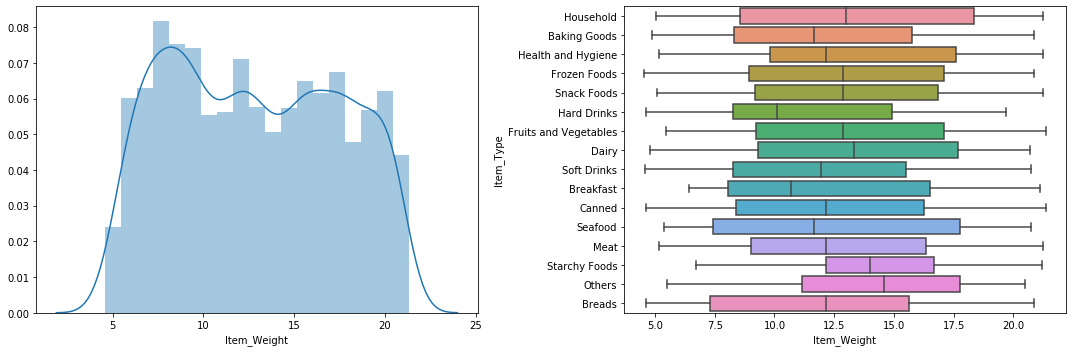

In [7]:
plt.subplot(121)
sns.distplot(train_data['Item_Weight'].dropna())

plt.subplot(122)
sns.boxplot(y='Item_Type',x='Item_Weight', data=train_data)

plt.tight_layout()
plt.show()

Вес всех продуктов распределён равномерно. Но интуитивно, вес продукта должен коррелировать с его типом: хлеб это, мясо или напиток. Поэтому заполним пропуски средним значением веса по типу продукта

In [8]:
d = train_data.groupby("Item_Type")['Item_Weight'].mean().to_dict()
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data['Item_Type'].apply(lambda x: d[x]))
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(test_data['Item_Type'].apply(lambda x: d[x]))

Аналогично, размер магазина должен коррелировать с его типом

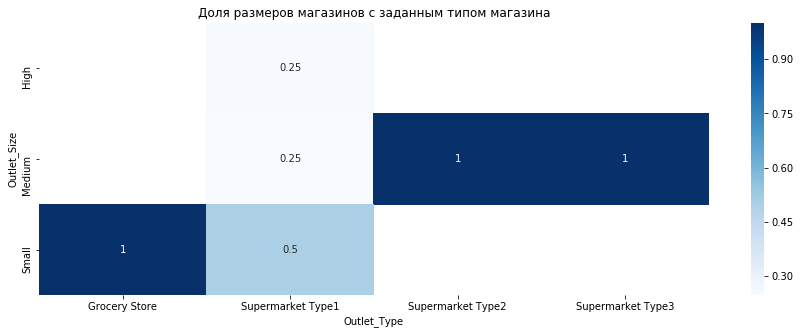

In [9]:
cds = train_data.pivot_table(index='Outlet_Size',columns='Outlet_Type',values='Outlet_Identifier',aggfunc='count')
cds = cds/cds.sum(0)
sns.heatmap(cds, cmap='Blues', annot=True)
plt.ylim(plt.ylim()[0]+0.5, plt.ylim()[1]-0.5)
plt.title('Доля размеров магазинов с заданным типом магазина');

Исходя из графика, самые вероятные варианты размера магазина:

In [10]:
d = {'Grocery Store':'Small',
     'Supermarket Type1':'Small',
     'Supermarket Type2':'Medium',
     'Supermarket Type3':'Medium',
    }
train_data['Outlet_Size'] = train_data['Outlet_Size'].fillna(train_data['Outlet_Type'].apply(lambda x: d[x]))
test_data['Outlet_Size'] = test_data['Outlet_Size'].fillna(test_data['Outlet_Type'].apply(lambda x: d[x]))

# EDA

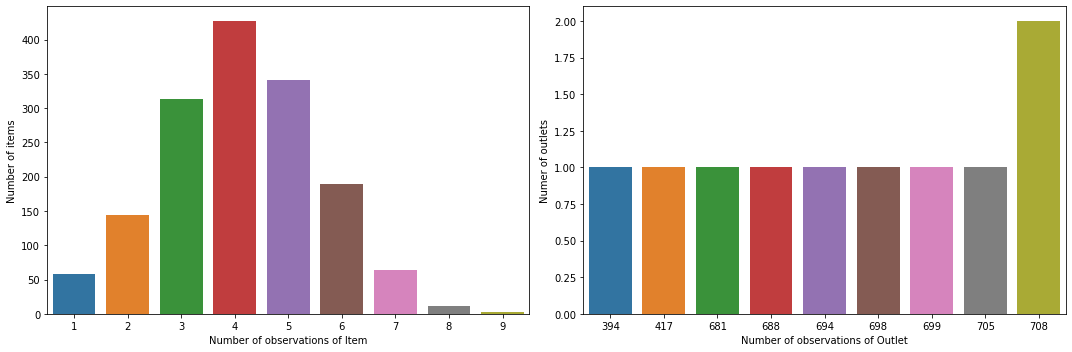

In [11]:
plt.subplot(121)
s = train_data['Item_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Item')
plt.ylabel('Number of items')

plt.subplot(122)
s = train_data['Outlet_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Outlet')
plt.ylabel('Numer of outlets')

plt.tight_layout()
plt.show()

В данных очень мало уникальных магазинов и продуктов - поэтому их можно определённым образом использовать в построении модели

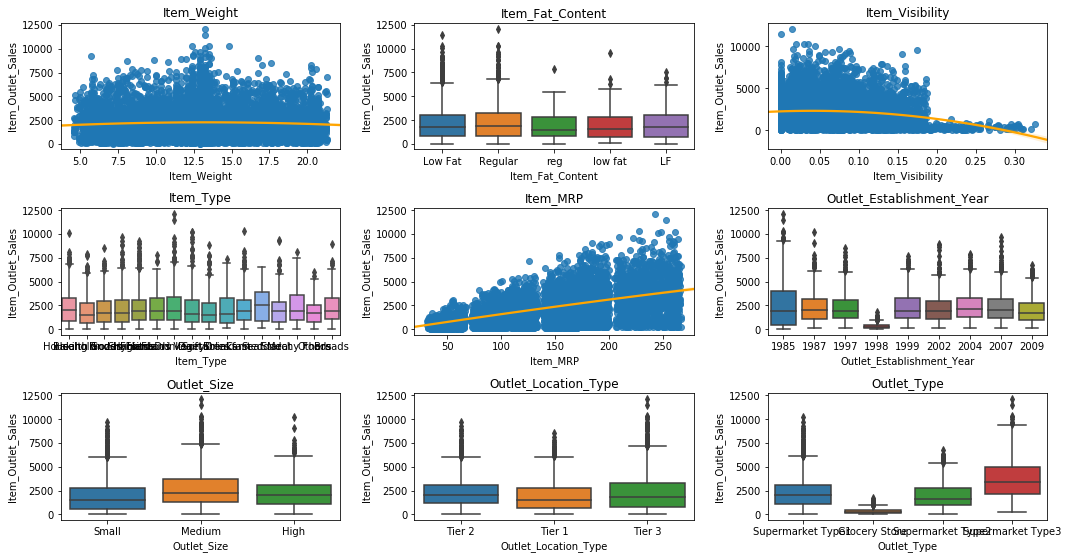

In [12]:
feats = list(data.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'],1).columns)
plt.figure(figsize=(15,10))
for idx, f in enumerate(feats):
    plt.subplot(len(feats)//3+1, 3, idx+1)
    if train_data[f].nunique()<30:
        sns.boxplot(x=f, y='Item_Outlet_Sales', data=train_data)
    else:
        sns.regplot(x=f, y='Item_Outlet_Sales', data=train_data, line_kws={'color':'orange'}, order=2)
    plt.title(f)

plt.tight_layout()
plt.show()

Что странного и интересного:
* Продукты, под которые отведено много полок плохо продаются. Это очень контринтуитивно
* Чем больше цена - тем больше продаж. Опять, очень странная зависимость, только если продажи даны не в штуках, а в ценах.
* Магазины 1998 года плохо продают товары. Скорее всего это просто выброс в данных
* Большой разброс продаж приходится на типы магазинов. Нужно посмотреть поподробнее
* Значения жирности продукта можно закодировать числами оставив между ними отношения порядка. То же с outlet_size. С outlet_location_type и outlet_type всё не так просто.
* Много значений жирности дублируют друг друга
* Остальные параметры не показывают ничего интересного

## Item Visibility

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

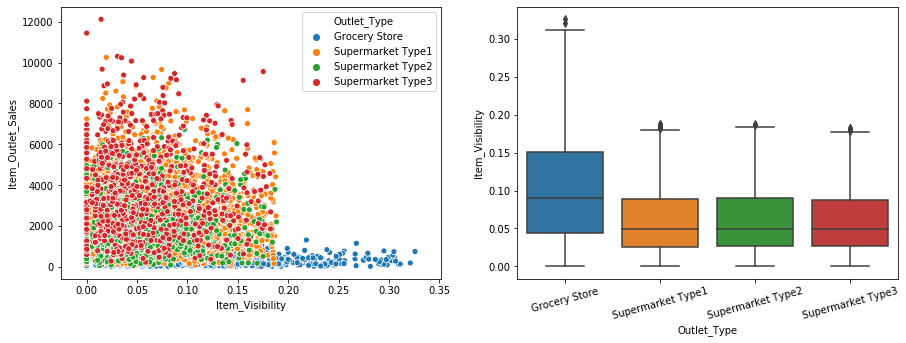

In [13]:
plt.subplot(121)
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_data.sort_values('Outlet_Type'), hue='Outlet_Type')

plt.subplot(122)
sns.boxplot(x='Outlet_Type',y='Item_Visibility', data=train_data.sort_values('Outlet_Type'))
plt.xticks(rotation=15)

Товары, для которых отведено много полок продаются плохо по той причине, что они продаются в продуктовых магазинах. Поэтому признак деления на типы магазинов уже должен показать такую зависимость. Но лучше добавить собственный бинарных флаг, выше порога которого все товары продаются только в grocery.

In [14]:
t = train_data[train_data['Outlet_Type']!='Grocery Store']['Item_Visibility'].max()
print(t)
train_data['Big_Visibility_Flag'] = train_data['Item_Visibility']>t
test_data['Big_Visibility_Flag'] = test_data['Item_Visibility']>t

0.18832266399999997


## Item MRP

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


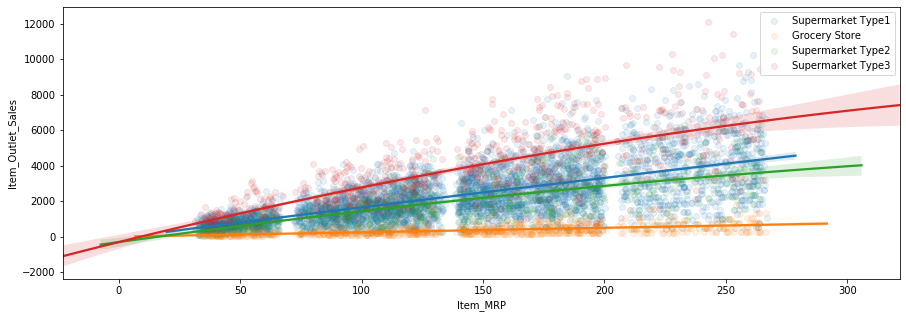

In [15]:
for v in train_data['Outlet_Type'].drop_duplicates().values:
    sns.regplot(x='Item_MRP',y='Item_Outlet_Sales',data=train_data[data['Outlet_Type']==v],
                scatter_kws={'alpha':0.1}, label=v, order=2)
plt.legend()
plt.show()

Товары продаются по разному в разных типах магазинов. Судя по тому, что значения Item_Outlet_Sales - дробные, то это продажи товаров в цене, а не в штуках. Тогда, прямые на графиках должны обозначать количество проданных товаров.

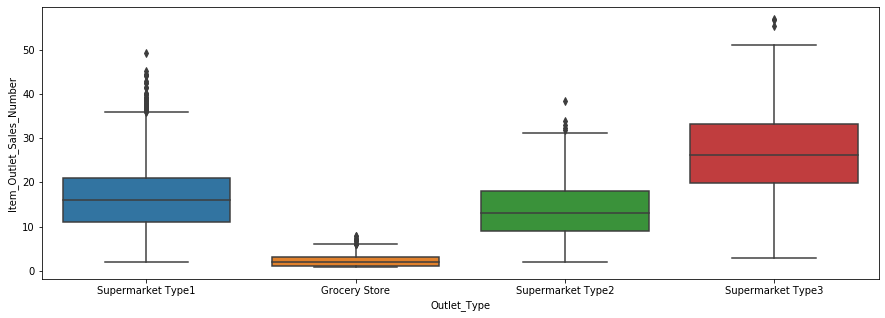

In [16]:
cds = train_data.copy()
cds['Item_Outlet_Sales_Number'] = cds['Item_Outlet_Sales']/cds['Item_MRP']
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales_Number', data=cds)
d = cds.groupby('Outlet_Type')['Item_Outlet_Sales_Number'].mean().to_dict()
train_data['Item_Outlet_Sales_Number'] = train_data['Outlet_Type'].apply(lambda x: d[x])
test_data['Item_Outlet_Sales_Number'] = test_data['Outlet_Type'].apply(lambda x: d[x])

# Item Type

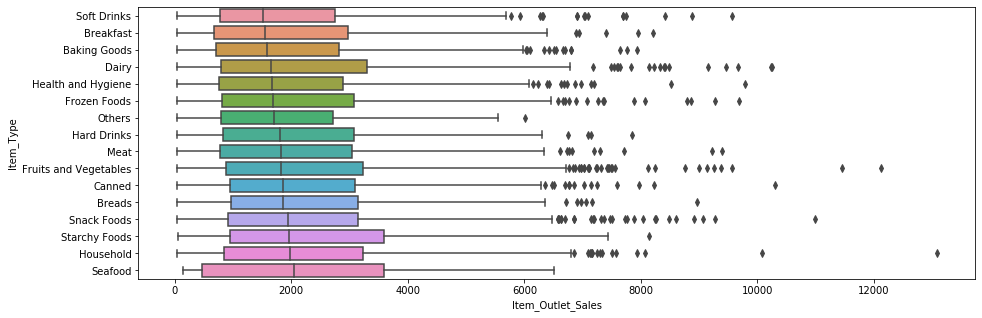

In [17]:
d = data.groupby('Item_Type')['Item_Outlet_Sales'].median().to_dict()
cds = data.copy()
cds['Mean_Sales_Per_Type'] = cds['Item_Type'].apply(lambda x: d[x])
cds = cds.sort_values('Mean_Sales_Per_Type')
sns.boxplot(y='Item_Type', x='Item_Outlet_Sales', data=cds);

Типы продуктов можно объединить по разделам: напитки, для дома, выпечка, быстрое приготовление и т.п. Но можно найти множество разных вариантов объединений - здесь нет какого-либо правильного ответа.

## Outlet Establishment year

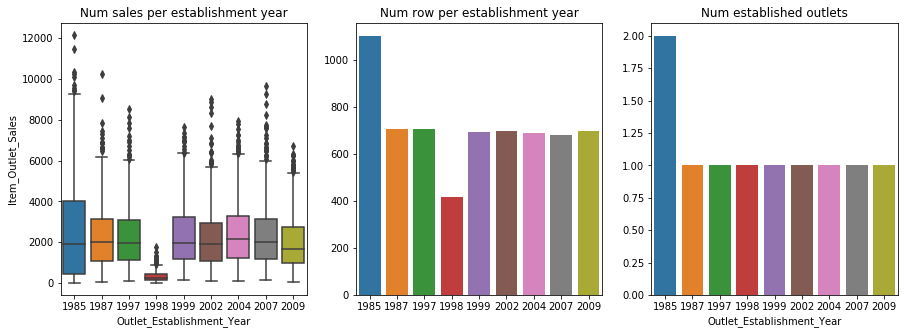

In [18]:
plt.subplot(131)
sns.boxplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=train_data)
plt.title('Num sales per establishment year')

plt.subplot(132)
s = train_data['Outlet_Establishment_Year'].value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num row per establishment year')

plt.subplot(133)
s = train_data.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].nunique().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num established outlets')


plt.show()

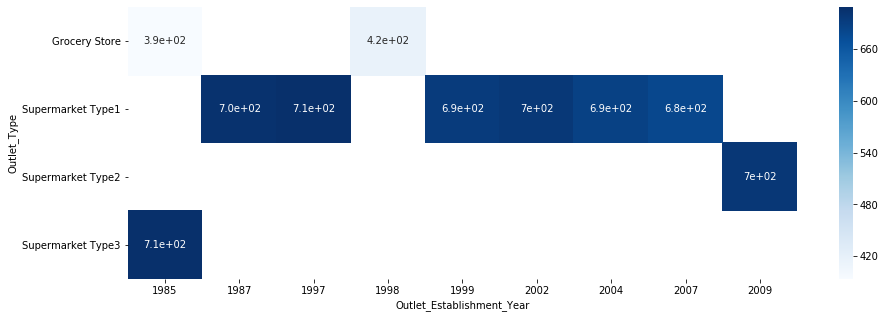

In [19]:
cds = train_data.pivot_table(index='Outlet_Type',columns='Outlet_Establishment_Year',
                       values='Outlet_Identifier', aggfunc='count')
sns.heatmap(cds, cmap='Blues', annot=True)
plt.ylim(plt.ylim()[0]+0.5, plt.ylim()[1]-0.5);

Причина низких продаж в магазинах, открытых в 1998 году - в том, что они относятся к Grocery Store.

Типы магазинов очень хорошо определяются через год их открытия, поэтому один из этих факторов лучше убрать. Признак года кажется является более сбалансированным по количеству значений, чем тип магазина. Для предсказания будем использовать именно год.

## Item Fat Content

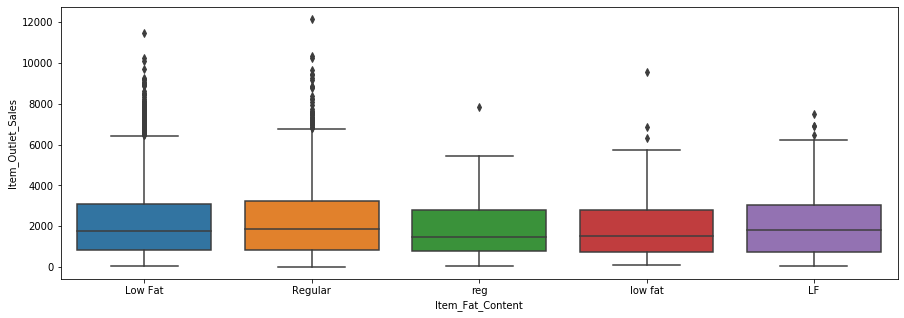

In [20]:
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=train_data)

Есть всего 2 уникальных значений жирности продукта: Regular и Low. Преобразуем переменную в бинарный признак

In [21]:
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].apply(lambda x: 'Regular' if x in ['Regular','reg'] else 'Low')
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].apply(lambda x: 'Regular' if x in ['Regular','reg'] else 'Low')

In [22]:
train_data['Regular_Fat_Flag'] = train_data['Item_Fat_Content']=='Regular'
test_data['Regular_Fat_Flag'] = test_data['Item_Fat_Content']=='Regular'

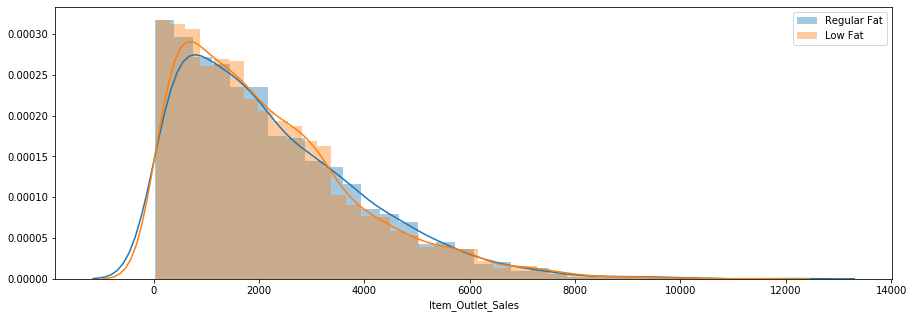

In [23]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales'], label='Low Fat')
plt.legend();

Данные почти не отличаются друг от друга. Но они ещё могут проявить себя при взаимодействии с другими признаками.

## Item Identifier

In [24]:
train_data['Item_Identifier'].head()

8376    NCJ54
7774    NCB19
7491    FDW60
2565    NCN05
4583    FDB05
Name: Item_Identifier, dtype: object

Идентификаторы товаров не похожи на простые id. Они могут нести какую-то важную информацию о товаре.

In [25]:
set([x[:2] for x in train_data['Item_Identifier']])

{'DR', 'FD', 'NC'}

In [26]:
print(sorted(set([x[2] for x in train_data['Item_Identifier']]))[:5])
print(len(sorted(set([x[2] for x in train_data['Item_Identifier']]))))

['A', 'B', 'C', 'D', 'E']
26


In [27]:
print(sorted(set([x[3:] for x in train_data['Item_Identifier']]))[:5])
print(len(sorted(set([x[3:] for x in train_data['Item_Identifier']]))))

['01', '02', '03', '04', '05']
60


Первые два символа в идентификаторе похожи на тип товара. Например FD может означать Food.
Затем идёт одна из букв английского алфавита.
Затем одно из чисел от 0 до 60

In [28]:
train_data['Item_Type_Big'] = [x[:2] for x in train_data['Item_Identifier']]
test_data['Item_Type_Big'] = [x[:2] for x in test_data['Item_Identifier']]

## Log

Целевая переменная сильно скошена влево и распределена примерно по логнормальному закону. Поэтому её лучше прологарифмировать и получить нечто похожее на нормальное распределение

In [29]:
train_data['Item_Outlet_Sales_log'] = np.log1p(train_data['Item_Outlet_Sales'])
test_data['Item_Outlet_Sales_log'] = np.log1p(test_data['Item_Outlet_Sales'])

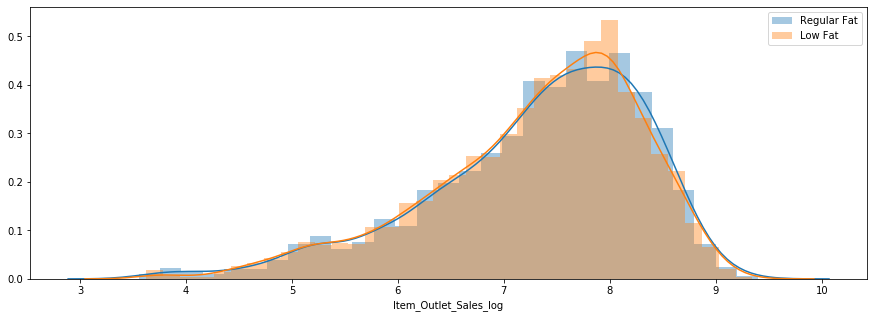

In [30]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales_log'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales_log'], label='Low Fat')
plt.legend();

## Categorial encoding

Разными способами закодируем категориальные факторы

In [31]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

Ordinal Encoding

Переведём категории в числа с сохранением порядка больше/меньше там, где это возможно

In [32]:
d = {'Small':0, 'Medium':1, 'High':2}
train_data['Outlet_Size_Enc'] = train_data['Outlet_Size'].apply(lambda x: d[x])
test_data['Outlet_Size_Enc'] = test_data['Outlet_Size'].apply(lambda x: d[x])

Категориальным признакам на которых нет отношений порядка просто поставим в соответствие какие-нибудь числа

In [33]:
for f in ['Item_Type', 'Item_Type_Big', 'Outlet_Location_Type','Outlet_Type', 'Item_Identifier','Outlet_Identifier']:
    le = LabelEncoder()
    train_data[f+'_Enc'] = le.fit_transform(train_data[f])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    test_data[f+'_Enc'] = [le_dict.get(x,-1) for x in test_data[f] ]#le.transform(test_data[f],)

Mean Encodings

Средние значения продаж для заданного категориального признака

In [34]:
for f in ['Item_Identifier','Item_Type', 'Item_Type_Big', 'Outlet_Identifier',
          'Outlet_Size','Outlet_Location_Type','Outlet_Type', 'Item_Fat_Content']:
    d = train_data.groupby(f)['Item_Outlet_Sales_log'].mean().to_dict()
    m = train_data['Item_Outlet_Sales_log'].mean()
    train_data[f+'_mean_enc'] = train_data[f].apply(lambda x: d[x])
    test_data[f+'_mean_enc'] = test_data[f].apply(lambda x: d.get(x,m))

One Hot Encodings

In [35]:
for f in ['Outlet_Location_Type','Outlet_Location_Type','Outlet_Type','Item_Type', 'Item_Type_Big']:
    for v in train_data[f].unique():
        train_data[f+'__'+str(v)] = train_data[f]==v
        test_data[f+'__'+str(v)] = test_data[f]==v

## Нормирование признаков

Нормирование необходимо для корректной оценки важности признаков при линейной регрессии, а также для правильной регуляризации

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
feats_to_scale = train_data.columns[-train_data.dtypes.isin([np.dtype('O'),np.dtype('bool')])]
feats_to_scale

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales',
       'Item_Outlet_Sales_Number', 'Item_Outlet_Sales_log', 'Outlet_Size_Enc',
       'Item_Type_Enc', 'Item_Type_Big_Enc', 'Outlet_Location_Type_Enc',
       'Outlet_Type_Enc', 'Item_Identifier_Enc', 'Outlet_Identifier_Enc',
       'Item_Identifier_mean_enc', 'Item_Type_mean_enc',
       'Item_Type_Big_mean_enc', 'Outlet_Identifier_mean_enc',
       'Outlet_Size_mean_enc', 'Outlet_Location_Type_mean_enc',
       'Outlet_Type_mean_enc', 'Item_Fat_Content_mean_enc'],
      dtype='object')

In [38]:
for f in feats_to_scale:
    scal = MinMaxScaler()
    train_data[f+'_scal'] = scal.fit_transform(train_data[[f]])
    test_data[f+'_scal'] = scal.transform(test_data[[f]])

# Напоследок проверим корреляцию между признаками

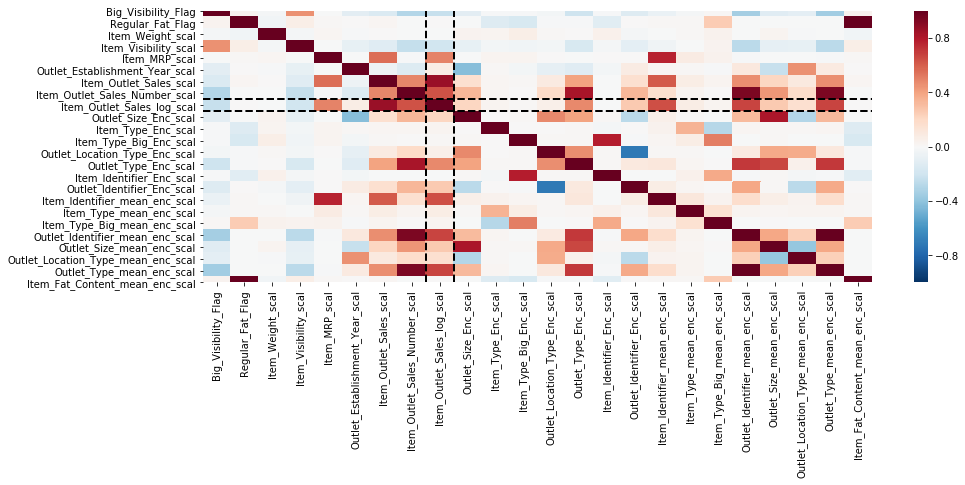

In [39]:
cds = train_data[[x for x in train_data.columns if '__' not in x and x not in feats_to_scale]].corr()
sns.heatmap(cds, cmap='RdBu_r', vmin=-1, vmax=1, annot=False)
for x in [8,9]:
    plt.axvline(x, linestyle='--', color='black', linewidth=2)
    plt.axhline(x, linestyle='--', color='black', linewidth=2)

Многие признаки сильно скоррелированы между собой. Особенно это заметно между mean_encoder'ами для магазинов

# Выбор метрики

Целевая переменная - доходы от продаж продукта - вещественное число. То есть текущая задача - регрессия.

Выбор метрик - MAE, MSE, MAPE, R2

Т.к. будем предсказывать логарифмированное значение продаж, которое имеет порядок единиц, то использование MAPE не принесёт ничего особо интересного.

R2 показывает скорее соответствие угаданной динамики продаж реальной. Нам же в данном случае более важны сами значения продаж.

Поэтому будем использовать метрики MAE, расчитанные как для логарифмированной величины, так и для оригинальной.

Остальные метрики будем расчитывать, но только для справки.

# Построение модели

In [40]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import Pool, CatBoostRegressor
from xgboost import XGBRegressor

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
res_ds = pd.DataFrame(columns=['name','mae_train','mae_test','r2_train','r2_test','features'])

In [43]:
def add_model_result(model, model_name, res_ds, train_data, test_data, feats, y_feat='Item_Outlet_Sales_log'):
    X_train = train_data[feats]
    X_test = test_data[feats]
    y_train, y_test = train_data[y_feat], test_data[y_feat]
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    res = {'name':model_name,
           'mae_train': mean_absolute_error(y_train, train_preds),
           'mae_test': mean_absolute_error(y_test, test_preds),
           'r2_train': r2_score(y_train, train_preds),
           'r2_test': r2_score(y_test, test_preds),
           'features':','.join(feats)}
    return res_ds.append(res, ignore_index=True)

## Baseline модели

Попробуем простую линейную модель.

Она не поддерживает категориальные признаки, поэтому передадим ей их кодировки в one-hot encoding и mean encoding

In [44]:
lr_feats = [x for x in train_data if '__' in x and x.split('__')[0]!='Outlet_Type'] + \
 ['Item_Weight', 'Item_Visibility', 'Item_MRP',
  'Outlet_Establishment_Year', 'Big_Visibility_Flag', 'Item_Outlet_Sales_Number',
  'Regular_Fat_Flag', 'Outlet_Size_Enc',
  'Item_Identifier_mean_enc','Item_Fat_Content_mean_enc','Item_Type_mean_enc', 'Item_Type_Big_mean_enc',
  'Outlet_Identifier_mean_enc','Outlet_Location_Type_mean_enc', 'Outlet_Type_mean_enc', 'Outlet_Size_mean_enc',
  
 ]
y_feat = 'Item_Outlet_Sales_log'

lr_feats = [x+'_scal' if x in feats_to_scale else x for x in lr_feats]

In [45]:
lr = Ridge(random_state=42)
lr.fit(train_data[lr_feats],train_data[y_feat])
res_ds = add_model_result(lr, 'ridge_base', res_ds, train_data, test_data, lr_feats)

Модель посложнее - CatBoost.

Он умеет автоматически обрабатывать категориальные признаки, но shap не поддерживает строковые значения, поэтому категориальные признаки в модель в виде чисел. Для признаков с большим количеством значений catBoost сам делает mean_encoding, но для надежности лучше передать вручную сгенерированные признаки.

In [46]:
cb_feats = ['Item_Identifier_Enc','Item_Weight','Item_Visibility','Item_Type_Enc','Item_MRP','Item_Type_Big_Enc',
           'Outlet_Identifier_Enc','Outlet_Establishment_Year','Outlet_Size_Enc','Outlet_Location_Type_Enc',
           'Big_Visibility_Flag','Item_Outlet_Sales_Number','Regular_Fat_Flag',
           ]+[x for x in train_data.columns if 'mean_enc' in x]
cat_feats = ['Item_Identifier_Enc','Item_Type_Enc', 'Item_Type_Big_Enc',
             'Outlet_Identifier_Enc','Outlet_Location_Type_Enc']
#train_pool = Pool(train_data[cb_feats], train_data[y_feat], cat_features=cat_feats)

In [47]:
cb = CatBoostRegressor(random_state=42,cat_features=cat_feats, verbose=False)
#cb.fit(train_pool, verbose=False, plot=True)
cb.fit(train_data[cb_feats], train_data[y_feat], plot=True)
res_ds = add_model_result(cb, 'cb_base', res_ds, train_data, test_data, cb_feats)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

XGBoost не поддерживает строковые переменные, поэтому передадим ему категориальные признаки в закодированном формате

In [48]:
xgb_feats = ['Item_Identifier_Enc','Item_Weight','Item_Visibility','Item_Type_Enc','Item_MRP', 'Item_Type_Big_Enc',
           'Outlet_Identifier_Enc','Outlet_Establishment_Year','Outlet_Size_Enc','Outlet_Location_Type_Enc',
           'Big_Visibility_Flag','Item_Outlet_Sales_Number','Regular_Fat_Flag',
            ] + [x for x in train_data.columns if '_mean_enc' in x]

In [49]:
xgb = XGBRegressor(random_state=42)
xgb.fit(train_data[xgb_feats], train_data[y_feat])
res_ds = add_model_result(xgb, 'xgb_base', res_ds, train_data, test_data, xgb_feats)

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


У RandomForest такие же требования к признакам, как и у XGBoost

In [50]:
rf_feats = xgb_feats

In [51]:
rf = RandomForestRegressor(random_state=42)
rf.fit(train_data[rf_feats], train_data[y_feat])
res_ds = add_model_result(rf, 'rf_base', res_ds, train_data, test_data, rf_feats)

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


А у Support Vector - такие же, как у Linear Regression

Сам по себе SVR может быть неинтересен, но позже пригодится в стэкинге моделей для получение более разнородного прогноза базовых моделей

In [52]:
svr_feats = lr_feats

In [53]:
svr = SVR()
svr.fit(train_data[svr_feats], train_data[y_feat])
res_ds = add_model_result(svr, 'svr_base', res_ds, train_data, test_data, svr_feats)

/opt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Grid Search

In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [62]:
num_iters = 100

Linear Regression

In [63]:
lr_grid_params = {'alpha':sorted(set(list(np.linspace(1e-2,100,100))+[1])),
                 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
#lr_grid_params

In [64]:
s = train_data.dtypes
s = s[s==np.dtype('bool')].index
train_data[s] = train_data[s].astype(float)

In [65]:
lr_gs = RandomizedSearchCV(Ridge(), lr_grid_params, random_state=42,
                           n_jobs=None, error_score=np.nan, n_iter=num_iters, verbose=1)
lr_gs.fit(train_data[lr_feats], train_data[y_feat])

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: ndarray is not C-contiguous

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

RandomizedSearchCV(cv='warn', error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': [0.01, 1, 1.02, 2.03, 3.04,
                                                  4.05, 5.06, 6.07, 7.08, 8.09,
                                                  9.1, 10.11, 11.12, 12.13,
                                                  13.14, 14.15, 15.16, 16.17,
                                                  17.180000000000003, 18.19,
                                                  19.200000000000003, 20.21,
                                                  21.220000000000002, 22.23,
                                                  23.240000000000002,
                       

In [66]:
lr_best = lr_gs.best_estimator_
res_ds = add_model_result(lr_best, 'ridge_best', res_ds, train_data, test_data, lr_feats)

Catboost

In [67]:
cb_grid_params = {'learning_rate':list(np.linspace(1e-5,1,100)),
                 'depth':np.linspace(4,16,4).astype(int),
                 'l2_leaf_reg':np.linspace(1e-2,100,10),
                 'cat_features':[cat_feats],
                 'iterations':[10]}
#cb_grid_params

In [68]:
cb_gs = RandomizedSearchCV(CatBoostRegressor(verbose=False), cb_grid_params, random_state=42,
                          n_jobs=None, error_score=np.nan, n_iter=num_iters, verbose=1)
cb_gs.fit(train_data[cb_feats], train_data[y_feat])

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv='warn', error_score=nan,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f0d35d62cc0>,
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'cat_features': [['Item_Identifier_Enc',
                                                          'Item_Type_Enc',
                                                          'Item_Type_Big_Enc',
                                                          'Outlet_Identifier_Enc',
                                                          'Outlet_Location_Type_Enc']],
                                        'depth': array([ 4,  8, 12, 16]),
                                        'iterations': [10],
                                        'l2_leaf_re...
                                                          0.16162454545454547,
                                                          0.17172545454545457,
                                                       

In [69]:
cb_best = cb_gs.best_estimator_
res_ds = add_model_result(cb_best, 'cb_best', res_ds, train_data, test_data, cb_feats)

XGBoost

In [70]:
xgb_grid_params = {'max_depth':np.linspace(3,50,5).astype(int),
                  'learning_rate':np.linspace(1e-6,1,10),
                  'n_estimators':np.linspace(10,100,10).astype(int)}
xgb_grid_params

{'max_depth': array([ 3, 14, 26, 38, 50]),
 'learning_rate': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
        5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 1.00000e+00]),
 'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])}

In [71]:
xgb_gs = RandomizedSearchCV(XGBRegressor(verbose=False), xgb_grid_params, random_state=42,
                           n_jobs=None, error_score=np.nan, n_iter=num_iters, verbose=1)
xgb_gs.fit(train_data[xgb_feats], train_data[y_feat])

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda/lib/python3

RandomizedSearchCV(cv='warn', error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1...
                   param_distributions={'learning_rate': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
       5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 

In [72]:
xgb_best = xgb_gs.best_estimator_
res_ds = add_model_result(xgb_best, 'xgb_best', res_ds, train_data, test_data, xgb_feats)

Random Forest

In [73]:
rf_grid_params = {
    'max_depth':np.linspace(3,50,5).astype(int),
    'min_samples_split': np.linspace(1,10,5).astype(int),
    'min_samples_leaf':np.linspace(1,10,5).astype(int),
}

In [74]:
rf_gs = RandomizedSearchCV(RandomForestRegressor(verbose=False), rf_grid_params, random_state=42,
                          n_jobs=None, error_score=np.nan, n_iter=num_iters, verbose=1)
rf_gs.fit(train_data[rf_feats], train_data[y_feat])

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got 

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got 

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be s

/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: Future

RandomizedSearchCV(cv='warn', error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=None,
      

In [75]:
rf_best = rf_gs.best_estimator_
res_ds = add_model_result(rf_best, 'rf_best', res_ds, train_data, test_data, rf_feats)

SVR

In [76]:
svr_grid_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree':np.linspace(1,10,5).astype(int),
                  'gamma':np.linspace(1e-2,1, 10),
                  'C':np.linspace(1e-2,1e2, 10)}

In [ ]:
8

In [ ]:
svr_gs = RandomizedSearchCV(SVR(verbose=False), svr_grid_params, random_state=42,
                           n_jobs=None, error_score=np.nan, n_iter=num_iters, verbose=1)
svr_gs.fit(train_data[svr_feats], train_data[y_feat])

/opt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
svr_best = svr_gs.best_estimator_
res_ds = add_model_result(svr_best, 'svr_best', res_ds, train_data, test_data, svr_feats)

In [ ]:
res_ds = res_ds.drop_duplicates()

## Stacking

Выберем лучшие модели каждого класса, из всех, полученных выше

In [ ]:
models = [base if res_ds.loc[name+'_base','mae_test']>res_ds.loc[name+'_best','mae_test'] else best
          for base,best,name in zip(
              [lr, cb, xgb, rf, svr],
              [lr_best, cb_best, xgb_best, rf_best, svr_best],
              ['ridge','cb','xgb','rf','svr'])]
feats = [lr_feats, cb_feats, xgb_feats, rf_feats, svr_feats]

In [ ]:
train_data.shape, test_data.shape

Если поделить обучающий датасет на 2 части: для обучения базовых моделей и для обучения ансамбля, - в каждой из них станет примерно такое же количество строк, сколько и в тесте.

Поэтому для обучения ансамблирующей модели будем использовать предсказания базовых моделей на всём датасете, а чтобы не было переобучения и ни одна базовая модель не предсказывала данные, на которых она обучалась - используем кросс-валидацию

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
train_stack_data = pd.DataFrame(index = range(len(train_data)), columns=[f'model_{i}' for i in range(len(models))])
test_stack_data = pd.DataFrame(index = range(len(test_data)), columns=[f'model_{i}' for i in range(len(models))])

In [ ]:
def train_base_models(models, feats, X,y, cat_feats=None):
    trained_models = []
    for m,fs in tqdm_notebook(zip(models, feats), total=len(models)):
        m.fit(X[fs], y)
        trained_models.append(m)
    return trained_models

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
train_data.index = range(len(train_data))

In [ ]:
for test_idxs, train_idxs in tqdm_notebook(
    KFold(n_splits=10).split(train_data, train_data[y_feat]),
    desc='Going KFolds', total=10,
):
    models = train_base_models(models, feats, train_data.loc[train_idxs], train_data.loc[train_idxs,y_feat], cat_feats)
    train_stack_data.loc[test_idxs] = np.vstack([m.predict(train_data.loc[test_idxs,fs]) for m, fs in zip(models,feats)]).T

Для получения предсказаний на тестовом датасете обучим базовые модели на всех базовых данных

In [ ]:
models = train_base_models(models, feats, train_data, train_data[y_feat], cat_feats)

In [ ]:
for idx, (m,fs) in enumerate(zip(models,feats)):
    test_stack_data[f'model_{idx}'] = m.predict(test_data[fs])

In [ ]:
cols = [f'model_{x}' for x in range(len(models))]
train_stack_data = pd.DataFrame(train_stack_data, columns=cols)
train_stack_data[y_feat] = train_data[y_feat]

test_stack_data = pd.DataFrame(test_stack_data, columns=cols)
test_stack_data[y_feat] = test_data[y_feat].values

Обучаем ансамблирующую модель на предсказаниях базовых

In [ ]:
lr_ens = Ridge(alpha=1)
lr_ens.fit(train_stack_data.drop(y_feat,1),train_stack_data[y_feat])
res_ds = add_model_result(lr_ens, 'stacked_base', res_ds, train_stack_data, test_stack_data, cols)

In [ ]:
lr_ens.coef_

In [ ]:
res_ds.tail()

# Важность признаков

In [ ]:
import shap

In [ ]:
res_ds.sort_values('mae_test').head()

Для интерпретации возмём xgboost модель, так как в ней:
    
    1) Мало признаков, поэтому влияния признаков наиболее "сконцентрирована"
    2) Поддерживается shap и не требует дополнительного указания категориальных признаков
    3) Качество всех моделей не отличается значительно, т.е. все они работают примерно одинаково, т.е. для анализа можно выбрать любую

In [ ]:
best_base_model = xgb
best_feats = xgb_feats

In [ ]:
explainer = shap.TreeExplainer(best_base_model)
sv = pd.DataFrame(explainer.shap_values(train_data[best_feats]), columns=best_feats)

In [ ]:
shap.summary_plot(sv.values, train_data[best_feats], max_display=10)

In [ ]:
shap.summary_plot(sv.values, train_data[best_feats], plot_type='bar', max_display=10)

* Item_Outlet_Sales_Number - количество продаж в типе магазина. Отображает низкие продажи в Grocery store
* Item_Identifier_mean_enc - средние продажи товара в магазинах
* Item_MRP - максимальная цена товара

# Результаты

Самая лучшая модель на отложенной выборке:

In [ ]:
res_ds = res_ds.sort_values('mae_test')
res_ds.head(1)

In [ ]:
y_true = test_data[y_feat.replace('_log','')]
preds = np.expm1(best_base_model.predict(test_data[best_feats]))
mae = mean_absolute_error(y_true, preds)
mae, mae/y_true.mean()

In [ ]:
res_ds['mae_test'].values[0]/test_data[y_feat].mean()

* MAE для логарифмированной величины: 0.44 (6% от средних логарифмированных продаж)
* MAE для величины продаж: 831 (38% от средних продаж)

In [ ]:
sns.distplot(test_data[y_feat.replace('_log','')], label='True values')
sns.distplot(preds, label='Predictions')
plt.legend()

Наиболее важные признаки:
* Item_Outlet_Sales_Number - количество продаж товара в магазине заданного типа
* Item_Identifier_mean_enc - средние продажи товара во всех магазинах
* Item_MRP - максимальная цена товара

In [ ]:
shap.summary_plot(sv.values, train_data[best_feats], plot_type='bar', max_display=3)

In [ ]:
pd.concat([train_data, test_data]).to_csv('modified_dataset.csv')

Лучше всего на повышение продаж товара влияет:

    1) Количество продаж товара
    2) Средние продажи товара в других магазинах
    3) Максимальная цена товара
    4) Возраст магазина
    5) Средние продажи в магазине

In [ ]:
shap.summary_plot(sv.values, train_data[best_feats], max_display=5)